# Ejercicios para regresión lineal

Vamos a poner en práctica lo que hemos visto en las clases pasadas. De entrada, cargamos las bibliotecas necesarias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from time import time

#Las siguientes dos son sólo para que las gráficas se vean chulas, pueden quitarlas
import seaborn as sns
sns.set()

from score import QLFScore

#Para desactivar un warning muy molesto
pd.options.mode.chained_assignment = None  # default='warn'

## Regresión lineal univariada

Considere el problema siguiente: Usted quiere estimar la constante de elasticidad $k$ de un resorte que genera una oscilación en una pelotita de masa $m = 12kg$. La ecuación de su movimiento está dada por

$$\frac{\partial^2 x(t)}{\partial t^2} = -\frac{k}{m} (x(t) - x_0)$$

A usted le han sido proporcionados las mediciones de la posición de la pelotita al tiempo $t$, pero vienen con un poco de ruido gaussiano en las coordenadas de la posición. Aproveche que las mediciones fueron tomadas a tiempos regulares y use la apoximación del operador de Laplace con errores a segundo orden:

$$ f''(t) \approx \frac{f(t + \Delta t) - 2 f(t) + f(t - \Delta t)}{\Delta t^2} + \mathcal{O}(\Delta t^2)$$

para estimar $k$ y $x_0$ por medio de una regresión lineal. Haga gráficas de dispersión para la aceleración y la posición, además de graficar la linea que mejor aproxima los datos.

In [2]:
#Les dejo mientras tanto los datos para que los vean
datos = pd.read_csv('data.csv')
df = pd.DataFrame(datos)
df.head()

,Posición,Tiempo
0,11.499958,0.000000
1,11.499788,0.013333
2,11.499258,0.026667
3,11.498414,0.040000
4,11.497071,0.053333


In [3]:
df.shape

(301, 2)

### Cálculo de la aceleración

In [4]:
"""
#Corrobora incrementos regulares de tiempo
deltas_t = []
for i in range(1, datos.shape[0]):
    delta_t = datos['Tiempo'][i] - datos['Tiempo'][i-1]
    deltas_t.append(delta_t)
delt = pd.Series(deltas_t)
delt

""" ;

Como los tiempos son regulares ($~\Delta t = 0.013333~$), usando la aproximación de Laplace:

$$\frac{\ d^2 x(t)}{\ dt^2} = -\frac{k}{m} (x(t) - x_0)$$

$$ \frac{\ d^2 x(t)}{\ dt^2}  \approx \frac{x(t + \Delta t) - 2 x(t) + x(t - \Delta t)}{\Delta t^2} + \mathcal{O}(\Delta t^2)$$

Como la fórmula de la aproximación requiere $~x(t-\Delta t)~$ y $~x(t+\Delta t)~$ empezaremos  con el índice 1 de las posiciones (haremos $a=0$ para $t=0$) y terminamos en el íncdice 300 (son 301 posiciones).

In [5]:
acel = [0] 
for i in range(1,df.shape[0]-1): 
    acel.append( (df.Posición[i+1] - 2*df.Posición[i] + df.Posición[i-1] ) / (0.013333)**2)

In [6]:
acel = pd.Series(acel, name='Aceleración')
df = df.join(acel)

In [7]:
df.head()

,Posición,Tiempo,Aceleración
0,11.499958,0.000000,0.000000
1,11.499788,0.013333,-2.027559
2,11.499258,0.026667,-1.760940
3,11.498414,0.040000,-2.809054
4,11.497071,0.053333,-1.923630


### Gráficas de posición y aceleración

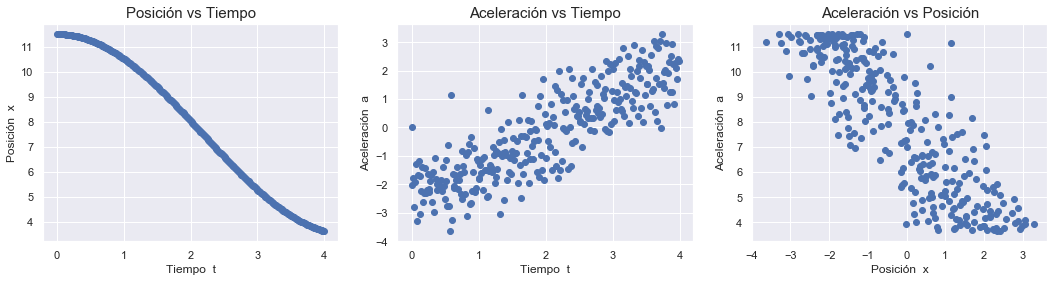

In [8]:
# Gráficas
plt.figure(figsize=(18,4))

t = df['Tiempo']
x = df['Posición']
a = df['Aceleración']

plt.subplot(1,3,1)
plt.scatter(t,x)
plt.title('Posición vs Tiempo', size=15)
plt.xlabel('Tiempo  t')
plt.ylabel('Posición  x')

plt.subplot(1,3,2)
plt.scatter(t,a)
plt.title('Aceleración vs Tiempo', size=15)
plt.xlabel('Tiempo  t')
plt.ylabel('Aceleración  a')

plt.subplot(1,3,3)
plt.scatter(a,x)
plt.title('Aceleración vs Posición', size=15)
plt.xlabel('Posición  x')
plt.ylabel('Aceleración  a')

plt.show()

### Aproximación lineal

Buscaremos la recta que mejor se ajusta a los datos de aceleración. Para esto calculamos los valores de la pendiente y ordenada al origen ($m_a~$ y $~b_a$):

Donde

$$ m_a = \frac{n \left(\sum_{i=1}^n x_i~a_i \right) - \left(\sum_{i=1}^n x_i \right) \left(\sum_{i=1}^n a_i \right)}{n \sum_{i=1}^n x_i^2 - \left(\sum_{i=1}^n x_i \right)^2} $$

$$ b_a = \frac{\left(\sum_{i=1}^n x_i^2 \right) \left(\sum_{i=1}^n a_i \right) - \left( \sum_{i=1}^n x_i \right) \left( \sum_{i=1}^n x_i~a_i\right)}{n \sum_{i=1}^n x_i^2 - \left(\sum_{i=1}^n x_i \right)^2} $$

In [9]:
def param_m(x,y):
    """x, y : are list"""
    n = len(x)
    nume = n*sum(x*y) - sum(x)*sum(y)
    deno = n*sum(x**2) - (sum(x))**2
    return nume/deno

def param_b(x,y):
    """x, y : are list"""
    n = len(x)
    nume = (sum(x**2)*sum(y)) - (sum(x)*sum(x*y))
    deno = n*sum(x**2) - (sum(x))**2
    return nume/deno

##### Parámetros (ACELERACIÓN-TIEMPO)

In [10]:
m_a1 = param_m(t[0:300], a[0:300])   # Eliminamos el último valor porque contiene un nan
b_a1 = param_b(t[0:300], a[0:300])
print("m_a1 =", m_a1)
print("b_a1 =", b_a1)

m_a1 = 1.1813801544895646
b_a1 = -2.5427055281052255


In [11]:
# Pendiente usando varianza y covarianza con numpy
num = np.cov(t[0:300], a[0:300])[0][1]
den = np.var(t[0:300])
m = num/den
print("m =",m)

m = 1.185331258685182


In [12]:
#Con statsmodel
lm = smf.ols(formula="Aceleración~Tiempo", data=df).fit()
lm.params

Intercept   -2.542706
Tiempo       1.181380
dtype: float64

##### Parámetros (ACELERACIÓN-POSICIÓN)

In [13]:
m_a2 = param_m(x[0:300], a[0:300])
b_a2 = param_b(x[0:300], a[0:300])
print("m_a2=", m_a2)
print("b_a2=", b_a2)

m_a2= -0.5142597969374938
b_a2= 3.8642193335231463


In [14]:
#Con statsmodel
lm_2 = smf.ols(formula="Aceleración~Posición", data=df).fit()
lm_2.params

Intercept    3.864219
Posición    -0.514260
dtype: float64

### Modelos: 

#### Aceleración vs Tiempo:  

$~~~~$Fórmula directa: $~~ a = -2.542706 + 1.181380~t ~~~~ ~~~~ ~~~~ ~~~~ $ Statsmodel: $~~ a = -2.542706 + 1.181380~t $


#### Aceleración vs Posición:

$~~~~$Fórmula directa: $~~ a =  3.864219 - 0.514260~x ~~~~ ~~~~ ~~~~ ~~~~ ~~$ Statsmodel: $~~ a =  3.864219 - 0.514260~x $

$ $

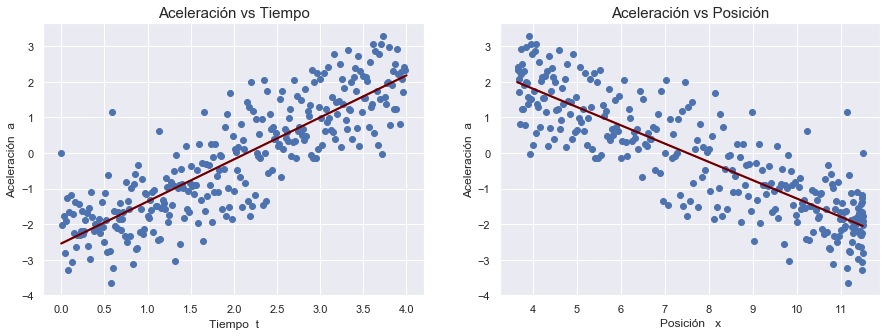

In [15]:
#GRÁFICAS

#Statsmodel 
a_mod_s1 = lm.params[0] + lm.params[1]*t       # (Acel-Tpo)
a_mod_s2 = lm_2.params[0] + lm_2.params[1]*x   # (Acel-Pos)

#Fórmula directa 
a_mod_f1 = b_a1 + m_a1*t     # (Acel-Tpo)
a_mod_f2 = b_a2 + m_a2*x     # (Acel-Pos)


plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.scatter(t,a)
plt.plot(t, a_mod_s1, color="red", linewidth=2)     # Statsmodel
plt.plot(t, a_mod_f1, color="black", linewidth=2, alpha=0.6)   # Fórmula

plt.title('Aceleración vs Tiempo', size=15)
plt.xlabel('Tiempo  t')
plt.ylabel('Aceleración  a')



plt.subplot(1,2,2)
plt.scatter(x,a)
plt.plot(x,a_mod_s2, color="red", linewidth=2)    # Statsmodel
plt.plot(x,a_mod_f2, color="black", linewidth=2, alpha=0.6)  # Fórmula

plt.title('Aceleración vs Posición', size=15)
plt.xlabel('Posición   x')
plt.ylabel('Aceleración  a')

plt.show()

Con la aproximación del modelo tenemos que 

$$ a = - 0.517752~x + 3.884838  \approx -\frac{k}{m} (x - x_0) = -\frac{k}{m} ~x ~+~ \frac{k~x_0}{m} $$

De modo que $$ \frac{k}{m} \approx 0.517752 \implies k \approx m (0.517752) = 12 (0.517752) = 6.213024 $$

y  $$ \frac{k~x_0}{m} \approx 3.884838 \implies x_0 \approx \frac{m}{k}(3.884838) = \left(\frac{12}{6.213024}\right)(3.884838) = 7.503280 $$

#### $k\approx~$6.213024
#### $x_0\approx~$7.503280

____

## Regresión multivariada

Ahora un poco más complicado pero no imposible. El archivo de datos 'casas.csv' contiene información sobre las características de 400 casas apócrifas, incluyendo el precio en el que han sido vendidas.

In [16]:
casas = pd.read_csv('casas.csv')
df2 = pd.DataFrame(casas)
df2.head()

,Precio,Zona,No_Baños,No_Cuartos,Superficie
0,4628135.0,3.0,1.0,1.0,120.0
1,2057167.0,1.0,2.0,3.0,581.0
2,396796.0,0.0,1.0,1.0,99.0
3,2729222.0,2.0,1.0,4.0,232.0
4,868960.0,0.0,1.0,2.0,283.0


Los campos son los siguientes:
1. **Precio**: Precio en que la casa fue vendida. Algunas casas son _demasiado caras_ y pueden meter ruido a la predicción.
2. **Zona**: Categoría del vecindario en el que la casa se encuentra. Las categorías van del 0 (la zona más fea) al 4 (Al lado del parque _La Mexicana_) Se sabe que los números no representan linealmente el ascenso en precio de las casas.
3. **No_Baños**: Número de baños en la casa
4. **No_Cuartos**: Número de cuartos en la casa
5. **Superficie**: Superficie de la casa

Busque un modelo lineal que pueda predecir el costo de una casa en la zona 3, de 2 baños y 4 recámaras con $300m^2$ de superficie.

Además de eso, de una interpretación de cada entrada del vector de parámetros del modelo.

Como parte final, para que comiencen a sentir el **poder**, aquí está una función que tomará $c$ el vector parámetro de su modelo, y lo evaluará en una partición de datos conocidos, a ver qué tan bien pueden predecir. La lambda que toma como segundo argumento es una función que se aplica a la columna "Zona". Relative es para dividir entre el precio medio aproximado de las casas (Sólo es para hacer el número un tanto más pequeño). Y así es como comienza la competencia.

*    QLFScore(c, zoneFunction = lambda j: j, relative = True)

In [17]:
#Solución aquí:

### Ecuaciones normales de la regresión

In [18]:
#Definiendo la funciónn que dará los parámetros
def params_c(matriz_data, variables, prediccion):
    
    matriz = matriz_data[variables]
    matriz.insert(0, 'Ones', np.ones(len(prediccion)))  # Agrega una columna de unos
    
    x = np.array(matriz)    # Genera la matriz X
    
    inversa = np.linalg.inv(np.dot(x.T, x))
    c = inversa.dot(np.dot(x.T, prediccion))
    #print(c)
    
    return c  # Regresa la lista de lista de parámetros empezando por los bias

##### Probando la función obteniendo los parámetros del ejercicio anterior :

In [19]:
df4 = df[0:300]
var = ['Posición']
predi = df4.Aceleración
c = params_c(df4, var, predi)
c

array([ 3.86421933, -0.5142598 ])

#### Calculamos ahora los parámetros para las casas con datos actuales :

In [20]:
variables = ['Zona', 'No_Baños', 'No_Cuartos', 'Superficie']
prediccion = df2.Precio

c = params_c(df2, variables, prediccion)
c

array([-1615758.30606518,  2196948.07194177,   328809.8291328 ,
         108897.4519795 ,     3410.75109916])

Cada entrada del vector anterior representa el peso que tiene cada variable en la predicción del precio.

$ precio =  2196948.07(Zona) + 328809.83(No\_Baños) + 108897.45(No\_Cuartos) + 3410.75(Superficie) - 1615758.31$

Veamos en precio de una vivienda en particular:

In [21]:
def precio_modelo_1(zona, banios, cuartos, superficie):
    precio = 2196948.07*zona + 328809.83*banios + 108897.45*cuartos + 3410.75*superficie - 1615758.31
    print("Caraterísticas de la casa: \n\n")
    print("Zona      = ", zona)
    print("Baños     = ", banios)
    print("Cuartos   = ", cuartos)
    print("Supeficie = ", superficie)
    print("Precio    =  $", int(precio))
    
    return precio

##### Características de la casa : zona 3, 1 baño, 1 recámara, 120$m^2$

In [22]:
precio1 = precio_modelo_1(3,1,1,120)

Caraterísticas de la casa: 


Zona      =  3
Baños     =  1
Cuartos   =  1
Supeficie =  120
Precio    =  $ 5822083


El precio de la casa, según los datos es de $4,628,135. Vemos que tenemos un error grande; de hecho lo podemos comprobar con la función QLFScore

In [23]:
QLFScore(c, zoneFunction = lambda j: j, relative = True)

399316.8821088355

El error es muy grande. Continuamos con el anáisis.

### Gráficas

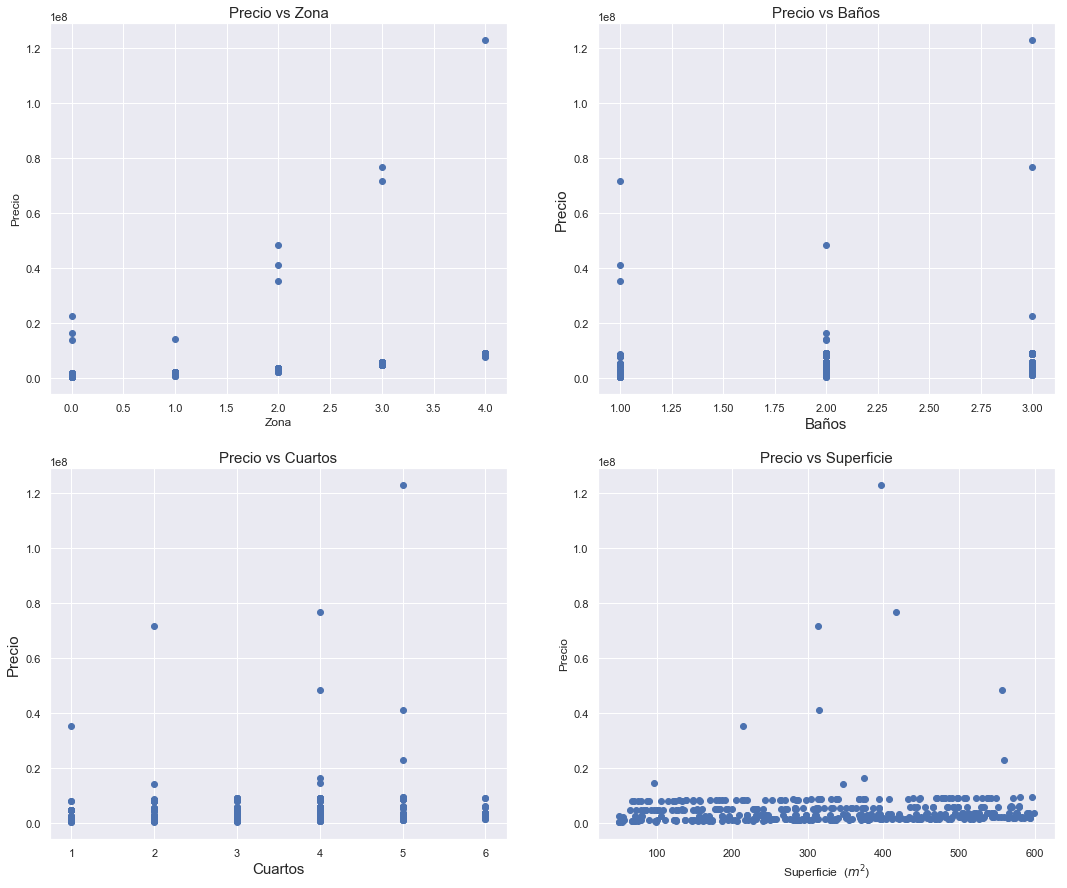

In [24]:
#Gráficos de dispersión
plt.figure(figsize=(18,15))

plt.subplot(2,2,1)
plt.scatter(df2.Zona, df2.Precio)
plt.title('Precio vs Zona', size=15)
plt.xlabel('Zona')
plt.ylabel('Precio')


plt.subplot(2,2,2)
plt.scatter(df2.No_Baños, df2.Precio)
plt.title('Precio vs Baños', size=15)
plt.xlabel('Baños', size=15)
plt.ylabel('Precio', size=15)

plt.subplot(2,2,3)
plt.scatter(df2.No_Cuartos, df2.Precio)
plt.title('Precio vs Cuartos', size=15)
plt.xlabel('Cuartos', size=15)
plt.ylabel('Precio', size=15)

plt.subplot(2,2,4)
plt.scatter(df2.Superficie, df2.Precio)
plt.title('Precio vs Superficie', size=15)
plt.xlabel(r'Superficie  ($m^2$)')
plt.ylabel('Precio')


plt.show()

Outliers:

De las gráficas podemos observar algunos valores que parecen atípicos. Veamos cuáles son.

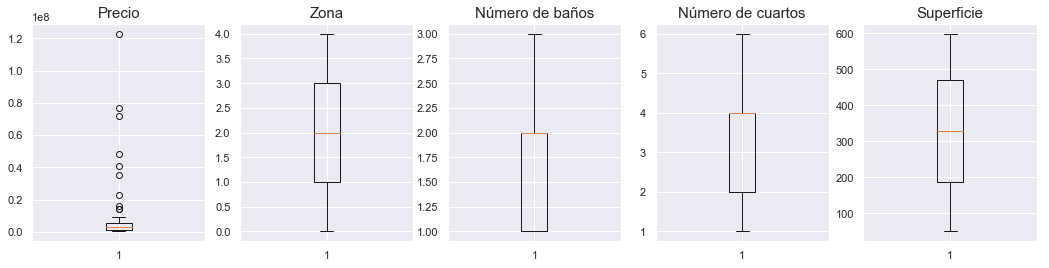

In [25]:
#Gráficos de caja

plt.figure(figsize=(18,4))
plt.subplot(1,5,1)
plt.boxplot(df2.Precio)
plt.title('Precio', size=15)

plt.subplot(1,5,2)
plt.boxplot(df2.Zona)
plt.title('Zona', size=15)

plt.subplot(1,5,3)
plt.boxplot(df2.No_Baños)
plt.title('Número de baños', size=15)

plt.subplot(1,5,4)
plt.boxplot(df2.No_Cuartos)
plt.title('Número de cuartos', size=15)

plt.subplot(1,5,5)
plt.boxplot(df2.Superficie)
plt.title('Superficie', size=15)

plt.show()

Quitando los 10 outliers:

In [26]:
max_precios = df2.sort_values('Precio', ascending=False)
max_precios.head(10)

,Precio,Zona,No_Baños,No_Cuartos,Superficie
369,122856258.0,4.0,3.0,5.0,397.0
294,76626130.0,3.0,3.0,4.0,417.0
114,71644020.0,3.0,1.0,2.0,314.0
345,48242222.0,2.0,2.0,4.0,557.0
340,41122508.0,2.0,1.0,5.0,315.0
243,35259826.0,2.0,1.0,1.0,214.0
149,22662542.0,0.0,3.0,5.0,559.0
250,16208500.0,0.0,2.0,4.0,374.0
23,14240702.0,1.0,2.0,4.0,97.0
158,13935726.0,0.0,2.0,2.0,347.0


##### Aquí hago una copia de los datos sin los valores atípicos:

In [27]:
df3 = df2[df2.Precio < 13935726]  # Data frame sin outliers

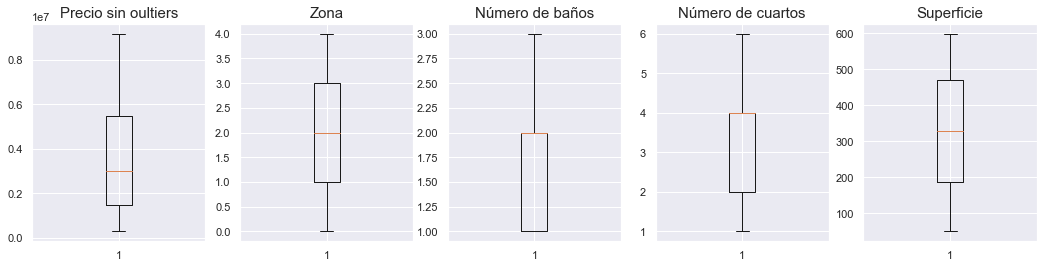

In [28]:
plt.figure(figsize=(18,4))
plt.subplot(1,5,1)
plt.boxplot(df3.Precio)
plt.title('Precio sin oultiers', size=15)

plt.subplot(1,5,2)
plt.boxplot(df2.Zona)
plt.title('Zona', size=15)

plt.subplot(1,5,3)
plt.boxplot(df2.No_Baños)
plt.title('Número de baños', size=15)

plt.subplot(1,5,4)
plt.boxplot(df2.No_Cuartos)
plt.title('Número de cuartos', size=15)

plt.subplot(1,5,5)
plt.boxplot(df2.Superficie)
plt.title('Superficie', size=15)

plt.show()

#### Grafico el precio respecto de cada variable

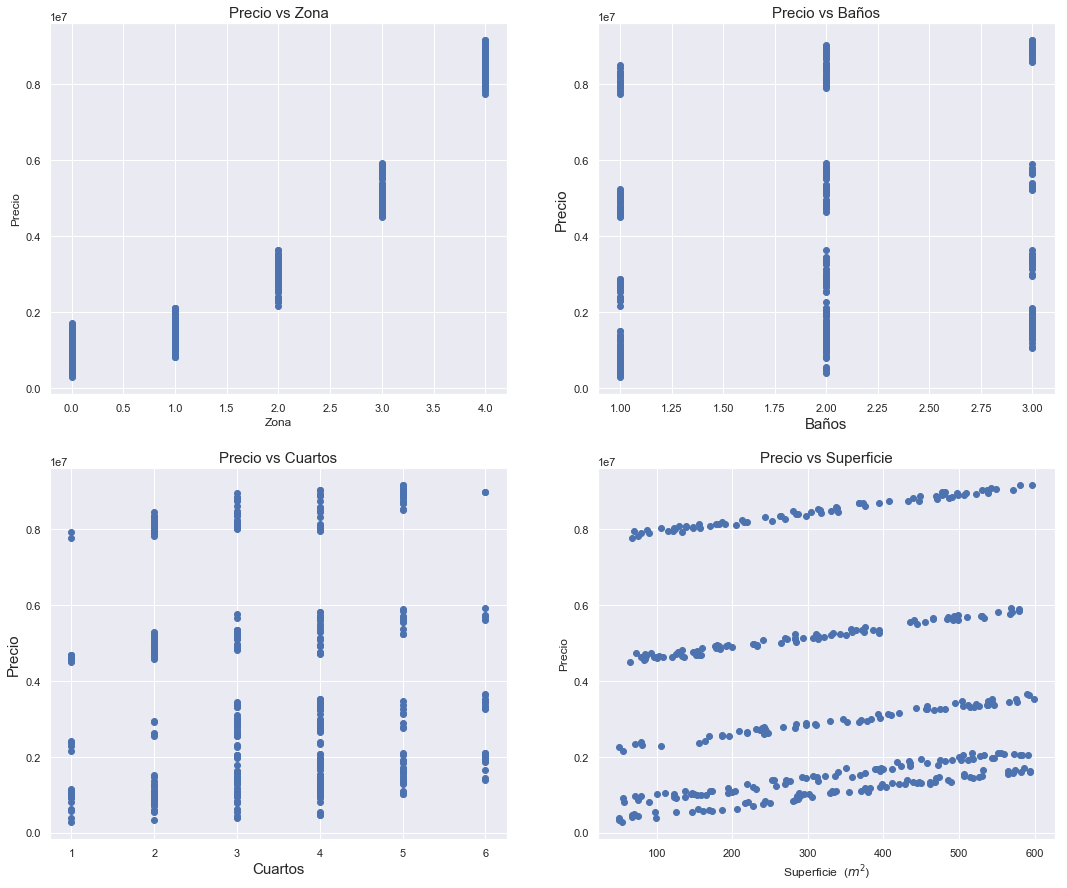

In [29]:
#Gráficos de dispersión actializadas

plt.figure(figsize=(18,15))

plt.subplot(2,2,1)
plt.scatter(df3.Zona, df3.Precio)
plt.title('Precio vs Zona', size=15)
plt.xlabel('Zona')
plt.ylabel('Precio')


plt.subplot(2,2,2)
plt.scatter(df3.No_Baños, df3.Precio)
plt.title('Precio vs Baños', size=15)
plt.xlabel('Baños', size=15)
plt.ylabel('Precio', size=15)

plt.subplot(2,2,3)
plt.scatter(df3.No_Cuartos, df3.Precio)
plt.title('Precio vs Cuartos', size=15)
plt.xlabel('Cuartos', size=15)
plt.ylabel('Precio', size=15)

plt.subplot(2,2,4)
plt.scatter(df3.Superficie, df3.Precio)
plt.title('Precio vs Superficie', size=15)
plt.xlabel(r'Superficie  ($m^2$)')
plt.ylabel('Precio')


plt.show()

Según la descripción en **Zona**, como se sabe que los números no representan linealmente el ascenso en precio de las casas, vamos a hacer una aproximación no lineal de este gráfico (tiene pinta de una exponencial o de una parábola).

###### Comprobación de una aproximación lineal:

In [30]:
df_model1 = df3[['Precio', 'Zona']]
variable = ['Zona']
predic = df_model1.Precio
c = params_c(df_model1, variable, predic)
c

array([ 144658.7722258 , 1841399.81180555])

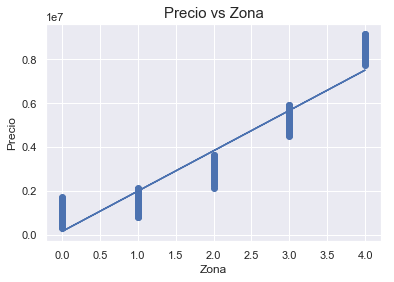

In [31]:
plt.scatter(df3.Zona, df3.Precio)
plt.plot(df3.Zona, 144658.7722258 + 1841399.81180555*df3.Zona)
plt.title('Precio vs Zona', size=15)
plt.xlabel('Zona')
plt.ylabel('Precio')
plt.show()

In [32]:
c_zona = [144658.7722258, 1841399.81180555, 0, 0, 0]
QLFScore(c_zona, zoneFunction = lambda j: j, relative = True)

77260.66475775704

Vemos que no se ajusta muy bien y que el error es grande sólo usando esa variable.

#### Correlación entre variables

("Necesitamos que ninguna de las variables que medimos sea la combinación lineal de otras. Aquí viene la importancia de la correlación! Y aunque la correlación entre columnas no sea 1, columnas con alta correlación volverán computacionalmente inestable a la inversión de la matriz de Gram.")

Una primera aproximación del precio está dado por la zona: $ 144658.7722258 + 1841399.81180555\cdot Zona $

Parece razonable pensar que el precio también depende de la superficie del terreno. A mayo superficie, mayor precio. Agregaremos esta variable y analizaremos la correlación con la zona.

Matriz de covarianza entre zona y superficie:

$$ \hat{\sigma}_{~z~s} = \frac{1}{n-1} \sum_{i=1}^n (z_i-\bar{z}~)(s_i-\bar{s}~) $$

In [33]:
df3[['Zona', 'No_Baños', 'No_Cuartos', 'Superficie']].corr()

,Zona,No_Baños,No_Cuartos,Superficie
Zona,1.000000,-0.046701,-0.014919,-0.081645
No_Baños,-0.046701,1.000000,0.494858,0.670292
No_Cuartos,-0.014919,0.494858,1.000000,0.564685
Superficie,-0.081645,0.670292,0.564685,1.000000


Podemos ver que las variables con alta correlación son: No_Baños-Superficie, No_Baños-No_Cuartos y No_Cuartos-Superficie.

La única que no mantiene correlación relevante con ninguna otra varible es la Zona (será nuestra primer variable independiente). En particular parece que Superficie es otra buena elección de variable independiente.

Iremos añadiendo las variables y sus interacciones para encontrar un mejor modelo (al usar la función QLFScore tendría que mostrar un error cuadrático menor).

In [34]:
variable = ['Zona', 'Superficie']
predic = df3.Precio
c = params_c(df3, variable, predic)
c

array([-688573.87760446, 1863625.48116667,    2419.16786605])

In [35]:
c = [-688573.87760446, 1863625.48116667, 0, 0,  2419.16786605]
QLFScore(c, zoneFunction = lambda j: j, relative = True)

88691.57575109326

(No es más pequeño; el anterior era de 77260.66)

$ $

Hasta ahora el mejor modelo es $$ precio = 144658.77 + 1841399.81(Zona) $$

In [36]:
def precio_modelo_2(zona, banios, cuartos, superficie):
    precio = 144658.77 + 1841399.81*zona
    print("Precio = $" + str(precio))    
    return precio

In [37]:
precio2 = precio_modelo_2(3,1,1,120)

Precio = $5668858.199999999


(Aún estamos muy por encim del valor real: $4,628,135)

##### Ahora vamos a considerar la aproximación cuadrática en la variable Zona. Transformamos dichos valores y vemos cómo se mejora el modelo:

In [38]:
df4 = df3.copy()
df4.Zona = df4.Zona**2
df4.head()

,Precio,Zona,No_Baños,No_Cuartos,Superficie
0,4628135.0,9.0,1.0,1.0,120.0
1,2057167.0,1.0,2.0,3.0,581.0
2,396796.0,0.0,1.0,1.0,99.0
3,2729222.0,4.0,1.0,4.0,232.0
4,868960.0,0.0,1.0,2.0,283.0


Visualización del comportamiento de Zona cuadrada:

In [39]:
variables = ['Zona']
predic = df4.Precio
c = params_c(df4, variables, predic)
c

array([1057633.2674221 ,  461633.13445715])

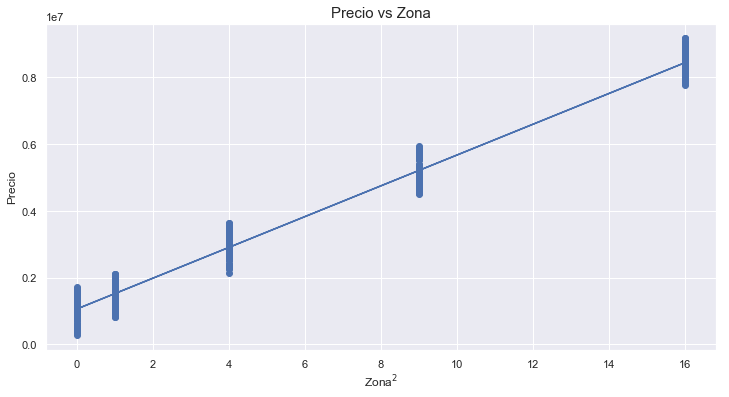

In [40]:
plt.figure(figsize=(12,6))
plt.scatter(df4.Zona, df4.Precio)
plt.plot(df4.Zona, 1057633.2674221 + 461633.13445715*df4.Zona)
plt.title('Precio vs Zona', size=15)
plt.xlabel(r'Zona$^2$')
plt.ylabel('Precio')
plt.show()

Calculamos nuevamente el vetor de parámtros con la variable modificada:

In [41]:
variables = ['Zona', 'No_Baños', 'No_Cuartos', 'Superficie']
predic = df4.Precio
c = params_c(df4, variables, predic)
c

array([100480.43450283, 466848.71176749,  16606.70482821,  50484.36491275,
         2208.44688945])

In [42]:
QLFScore(c, zoneFunction = lambda j: j**2, relative = True)

50.138336994331375

El error dismunuyó muy significativamente. Con este vector podemos crear un mejor modelo.

In [43]:
def precio_modelo_3(zona, banios, cuartos, superficie):
    precio = 100480.43450283 + 466848.71176749*(zona**2) + 16606.70482821*banios + 50484.36491275*cuartos + 2208.44688945*superficie 
    print("Precio = $" + str(precio))
    return precio

In [44]:
precio3 = precio_modelo_3(3,1,1,120)

Precio = $4634223.5368852


Claramente se ve una mejor estimación del valor real: $ \$ 4,628,135$  (Con una diferencia de $\$6,088$)

### Ahora vamos a variar un poco el exponente para ver si encontramos uno que de menor error:

In [45]:
#Definimos la función que hará las iteraciones de ajuste

def minimo_error(df, var_indep, var_dep, incrementos):


    parametros = []
    errores_cuad = []
    potencias = []
        
    for i in incrementos:
        data = df.copy()
        data.Zona = data.Zona**(2+i)
        
        c = params_c(data, var_indep, var_dep)
        #print(c)
        parametros.append(c)
        
        error = QLFScore(c, zoneFunction = lambda j: j**(2+i), relative = True)
        errores_cuad.append(error)
        potencias.append(2+i)
        
        #print("\nPOTENCIA=", 2+i)
        #print("ERROR=", error, "\n\n")
        
    minimo = min(errores_cuad)
    indice = errores_cuad.index(minimo)
    
    print("\n")
    print("\nError cuadrático mínimo : ", minimo)
    print("\nVector de parámetros    : ", parametros[indice])
    print("\nPotencia asociada       : ", potencias[indice])
    
    return minimo, parametros[indice], potencias[indice]

Ajustamos los argumentos de la función y entrenamos:

In [46]:
incrementos = [x*0.0001 for x in range(-50, 50)]  # Irá incrementando 0.0001 unidades por iteración
var_indep = ['Zona', 'No_Baños', 'No_Cuartos', 'Superficie']
var_dep = df3['Precio']

In [47]:
time1 = time()
optimo = minimo_error(df3, var_indep, var_dep, incrementos)
time2 = time()

tiempo_ejecucion = time2 - time1
print("\n\nTiempo de ejecución: " + str(round(tiempo_ejecucion, 3)) + " segundos \n\n")




Error cuadrático mínimo :  49.69016942111481

Vector de parámetros    :  [103147.5610602  464619.04764395  16320.55316249  50491.79495176
   2209.0995577 ]

Potencia asociada       :  2.0034


Tiempo de ejecución: 0.54 segundos 




Por lo tanto, el mejor modelo de predicción hasta ahora es:

$$ Precio = 103147.56 + 464619.05(Zona) + 16320.55(Baños) + 50491.79(Cuartos) + 2209.10(Superficie) $$

In [48]:
def precio_mejor_modelo(zona, banios, cuartos, superficie):
    precio = 103147.5610602 + 464619.04764395*(zona**2) + 16320.55316249*banios + 50491.79495176*cuartos + 2209.0995577*superficie 
    print("Caraterísticas de la casa: ")
    print("\tZona      = ", zona)
    print("\tBaños     = ", banios)
    print("\tCuartos   = ", cuartos)
    print("\tSupeficie = ", superficie)
    print("\tPrecio    =  $", int(precio))
    
    return precio

### Vamos a estimar el precio de algunas casas, comenzando por la que hemos venido comparando:

In [49]:
precio_mejor = precio_mejor_modelo(3,1,1,120)

Caraterísticas de la casa: 
	Zona      =  3
	Baños     =  1
	Cuartos   =  1
	Supeficie =  120
	Precio    =  $ 4616623


In [50]:
print("Diferencia = ", 4634223 - 4616623)

Diferencia =  17600


La diferencia es mayor que cuando teníamos el modelo 3. Habría que revisar si el modelo 3 se ajusta mejor las características de esta casa, pero no muy bien a la de otras. Es decir, hay que evaluar si este nuevo modelo se ajustó mejor a la mayoría de los datos y no sólo pensar que se desajustó más que antes. 

Veamos cómo se comporta éste, añadiendo una columna de precios predictorios al data frame:

In [51]:
df2['Modelo_Precio'] = (103147.5610602 + 464619.04764395*(df2['Zona']**2) + 16320.55316249*df2['No_Baños'] 
                        + 50491.79495176*df2['No_Cuartos'] + 2209.0995577*df2['Superficie'])

In [52]:
df2 = df2.astype('int')

In [53]:
df2['Diferencia'] = df2.Precio - df2.Modelo_Precio

In [54]:
df2.head()

,Precio,Zona,No_Baños,No_Cuartos,Superficie,Modelo_Precio,Diferencia
0,4628135,3,1,1,120,4616623,11512
1,2057167,1,2,3,581,2035369,21798
2,396796,0,1,1,99,388660,8136
3,2729222,2,1,4,232,2692422,36800
4,868960,0,1,2,283,845626,23334


In [55]:
df5 = df2[df2.Precio < 13935726]

In [56]:
df5['Porcentaje_Error'] = round(abs((df5['Diferencia'] / df5['Precio'])*100), 4)

In [57]:
df5.head()

,Precio,Zona,No_Baños,No_Cuartos,Superficie,Modelo_Precio,Diferencia,Porcentaje_Error
0,4628135,3,1,1,120,4616623,11512,0.2487
1,2057167,1,2,3,581,2035369,21798,1.0596
2,396796,0,1,1,99,388660,8136,2.0504
3,2729222,2,1,4,232,2692422,36800,1.3484
4,868960,0,1,2,283,845626,23334,2.6853


In [58]:
print("Error máximo: ", df5.Porcentaje_Error[df5.Porcentaje_Error.idxmax()], "%")
print("Error mínimo: ", df5.Porcentaje_Error[df5.Porcentaje_Error.idxmin()], "%")

Error máximo:  4.9074 %
Error mínimo:  0.0005 %


### El modelo es muy bueno. Procedo a continuar con la estimación del precio de la casa objetivo:

#### Características que pedían:  zona 3, baños 2, recámaras 4, superficie 300$m^2$

In [59]:
casa_objetivo = precio_mejor_modelo(3,2,4,300)

Caraterísticas de la casa: 
	Zona      =  3
	Baños     =  2
	Cuartos   =  4
	Supeficie =  300
	Precio    =  $ 5182057


### Una casa con las características anteriores costaría aproximadamente  $ \$5,182,057 $

##### Características de la casa 3: zona 2, 2 baños, 2 recámaras, 89$m^2$

In [60]:
costo_1 = precio_mejor_modelo(2,2,2,89)

Caraterísticas de la casa: 
	Zona      =  2
	Baños     =  2
	Cuartos   =  2
	Supeficie =  89
	Precio    =  $ 2291858
